In [29]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
import warnings
import os
import zipfile
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [31]:
dataset_dir = 'dataset'

In [32]:
target_file = 'traffic-prediction-dataset.zip'

In [33]:
extracting = zipfile.ZipFile(target_file, 'r')
extracting.extractall(dataset_dir)
extracting.close()

In [34]:
df = pd.read_csv(f'{dataset_dir}/traffic.csv')

In [35]:
df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [36]:
print(df['DateTime'].dtype)

object


In [37]:
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [38]:
df.head()


,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [39]:
print(df['DateTime'].dtype)


datetime64[ns]


In [40]:
df['Hour'] = df['DateTime'].dt.hour
df['DayOfWeek'] = df['DateTime'].dt.dayofweek
df['Month'] = df['DateTime'].dt.month

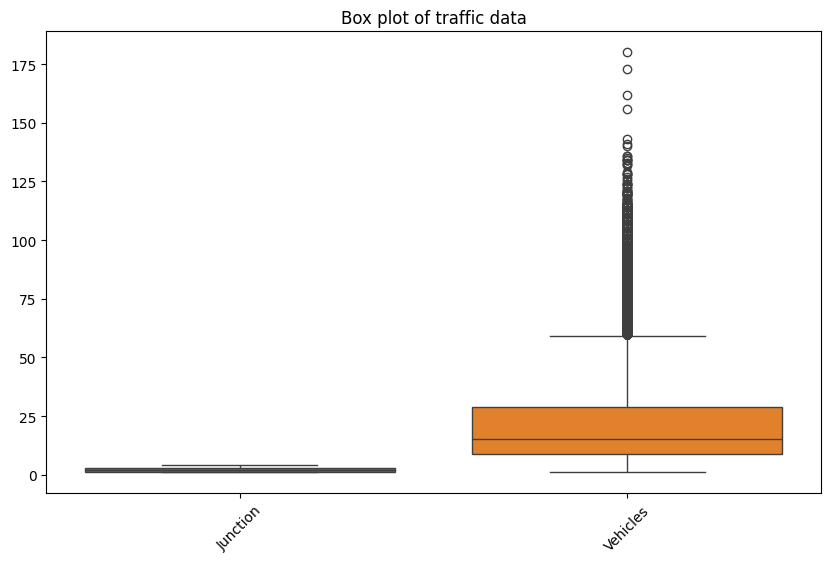

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['Junction', 'Vehicles']])
plt.title('Box plot of traffic data')
plt.xticks(rotation=45)
plt.show()

In [41]:
scaler = MinMaxScaler()
df_normalized = scaler.fit_transform(df[['Junction', 'Vehicles', 'Hour', 'DayOfWeek', 'Month']])
df_normalized = pd.DataFrame(df_normalized, columns=['Junction', 'Vehicles', 'Hour', 'DayOfWeek', 'Month'])

X = df_normalized[['Junction', 'Hour', 'DayOfWeek', 'Month']]
y = df_normalized['Vehicles']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the training and testing sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (38496, 4) (38496,)
Testing set shape: (9624, 4) (9624,)


In [42]:
Q1 = df['Vehicles'].quantile(0.25)
Q3 = df['Vehicles'].quantile(0.75)
IQR = Q3 - Q1
threshold = 1.5
outlier_mask = (df['Vehicles'] < (Q1 - threshold * IQR)) | (df['Vehicles'] > (Q3 + threshold * IQR))
df_cleaned = df[~outlier_mask]

scaler = MinMaxScaler()
df_normalized = scaler.fit_transform(df_cleaned[['Junction', 'Vehicles']])
df_normalized = pd.DataFrame(df_normalized, columns=['Junction', 'Vehicles'])

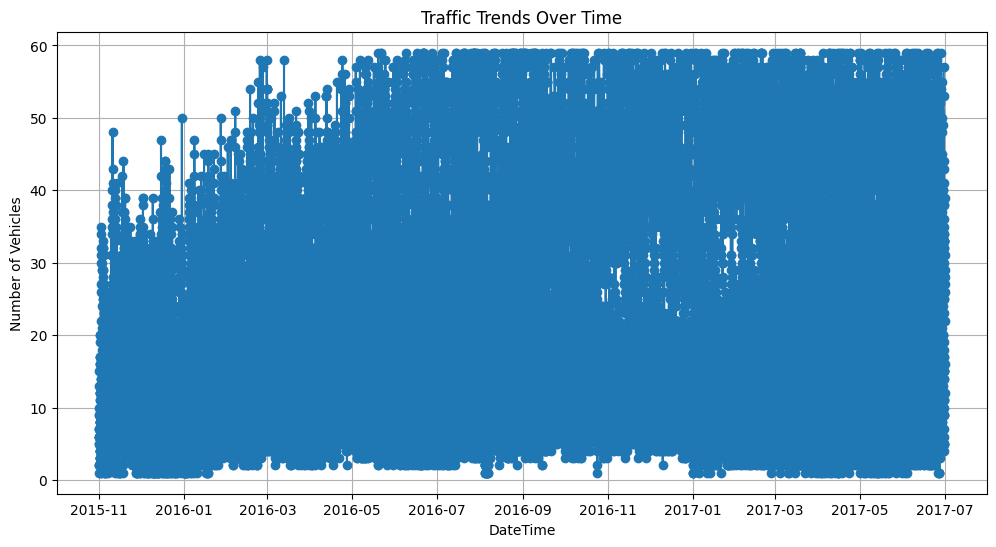

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_cleaned['DateTime'], df_cleaned['Vehicles'], marker='o', linestyle='-')
plt.title('Traffic Trends Over Time')
plt.xlabel('DateTime')
plt.ylabel('Number of Vehicles')
plt.grid(True)
plt.show()

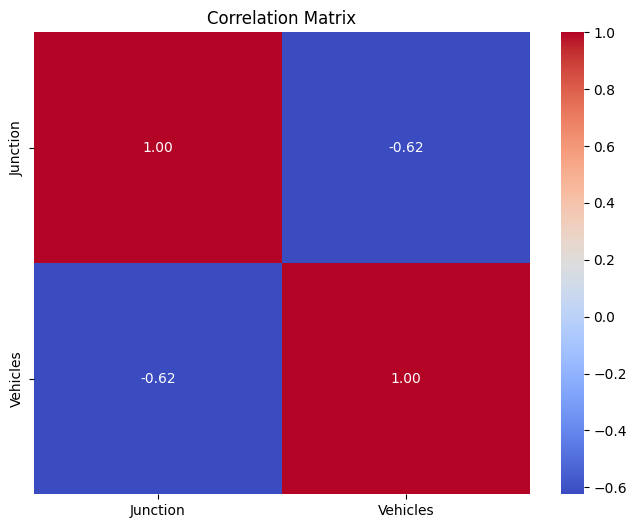

In [43]:
correlation_matrix = df_cleaned[['Junction', 'Vehicles']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [44]:
X = df_normalized[['Junction']]
y = df_normalized['Vehicles']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
degree = 2
poly_features = PolynomialFeatures(degree=degree)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

In [49]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,241 (8.75 KB)

 Trainable params: 2,241 (8.75 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.2, verbose=1)

# Prediction of values
y_pred = model.predict(X_test)
y_pred = y_pred.squeeze()

# Calculation of metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

Epoch 1/25
891/891 ━━━━━━━━━━━━━━━━━━━━ 2s 929us/step - loss: 0.0412 - mae: 0.1472 - val_loss: 0.0254 - val_mae: 0.1176
Epoch 2/25
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 765us/step - loss: 0.0254 - mae: 0.1207 - val_loss: 0.0251 - val_mae: 0.1199
Epoch 3/25
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 780us/step - loss: 0.0258 - mae: 0.1221 - val_loss: 0.0254 - val_mae: 0.1223
Epoch 4/25
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 778us/step - loss: 0.0256 - mae: 0.1218 - val_loss: 0.0255 - val_mae: 0.1240
Epoch 5/25
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 780us/step - loss: 0.0261 - mae: 0.1225 - val_loss: 0.0249 - val_mae: 0.1189
Epoch 6/25
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 755us/step - loss: 0.0258 - mae: 0.1216 - val_loss: 0.0250 - val_mae: 0.1184
Epoch 7/25
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/step - loss: 0.0252 - mae: 0.1206 - val_loss: 0.0248 - val_mae: 0.1181
Epoch 8/25
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 771us/step - loss: 0.0255 - mae: 0.1206 - val_loss: 0.0249 - val_mae: 0.1186
Epoch 9/25
891/891 ━━━━━━━━━━━━━━━━━━━━ 

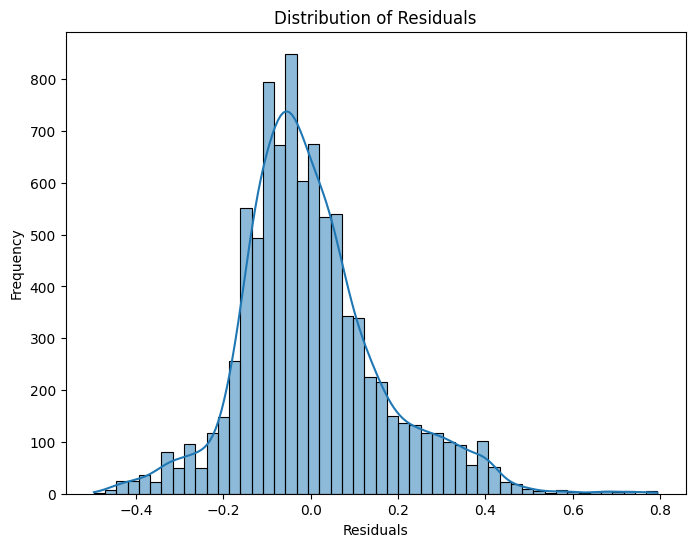

In [51]:
residuals = y_test - y_pred
\
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()